# Deep Learning Lab3

**10185501402 孙秋实 2018级**

本节课我们实现包含隐层的神经网络模型，并在手写数字识别数据集MNIST上进行测试。

**实验摘要：**

**我选择重新写这次实验的代码，并且使用了以下方法提升这个手写神经网络在MNIST数据集上的表现：**
1. 使用Softmax激活函数和Cross Entropy损失函数的组合
2. 使用了Mini-batch梯度下降方法
3. 使用了如下初始化方法，比较在较少的训练轮次模型收敛速度和拟合情况：
     1. 完全随机初始化
     2. Xavier初始化
     3. Kaiming/MSRA初始化
4. 使用了如下优化器，比较在较少的训练轮次模型收敛速度和拟合情况：
     1. AdaGrad Optimizer
     2. RMSProp Optimizer
     3. Adam Optimizer

**建立多个网络用于测试各种算法的有效性，最终选择表现比较好的Kaiming/MSRA初始化 + RMSProp优化方法进行训练，配合学习率衰减防止震荡，最后加入正则化项缓解过拟合问题。**


## 数据集

手写数字识别数据集

下载链接：https://www.kaggle.com/c/digit-recognizer/data

（本节课仅需要训练集）

先导入相应的包

In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from collections import OrderedDict

从DataFrame中读取x与y，转化为numpy数组

In [2]:
def get_data(data):
    x = data[[i for i in list(data.columns) if i != "label"]].values
    x_train = np.array(x)
    x_train = x_train.astype(np.float64)
    mean_image = np.mean(x_train, axis=0)
    x_train -= mean_image
    # 将标签转化为 one-hot 向量
    y_list = []
    for i in data["label"]:
        y = [0] * 10
        y[i] = 1
        y_list.append(y)
    return x_train/20, np.array(y_list)

Remark:如果不是one-hot向量，衡量损失的时候不同数字的错误就会返回不平等的损失，比如把9错判为0的损失会是把1错判为0的损失的81倍

In [3]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def feed_forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    def feed_backward(self, dout):
        dx = np.dot(dout, self.W.T) 
        self.dW = np.dot(self.x.T, dout) 
        self.db = np.sum(dout, axis=0)   # 反向传播bias项
        return dx

实现RELU激活函数，大于零不做改变，小于零抹为0

In [4]:
class Relu(): # RELU激活函数，大于零不做改变，小于零抹为0
    def __init__(self):
        self.mask = None 
        
    def feed_forward(self, x):
        self.mask = (x <= 0)   
        out = x.copy()           
        out[self.mask] = 0       
        return out

    def feed_backward(self, dout):
        dout[self.mask] = 0 # 下游梯度传播
        dx = dout
        return dx

实现Softmax函数，返回一个和为1的概率分布

$$S_{i}=\frac{e^{i}}{\sum_{j} e^{j}}$$

In [5]:
def softmax(x): 
    if x.ndim == 2: 
        x = x.T 
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    # 防止溢出
    x = x - np.max(x) 
    return np.exp(x) / np.sum(np.exp(x))

实现Softmax函数的损失计算

In [6]:
class Softmax_With_Loss:
    def __init__(self):
        self.loss = None 
        self.y = None 
        self.t = None 

    def feed_forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = Cross_Entropy_Loss(self.y, self.t)
        return self.loss

    def feed_backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size 
        return dx

In [7]:
def Cross_Entropy_Loss(y, t):
    epsilon = 1e-07 
    # 这里需要设置一个极小值防止log0
    return - np.sum(t * np.log(y + epsilon)) 

权重初始化是神经网络训练任务中比较关键的一环（比如全部初始化为相同的值或者全0就废了...）在这里我们测试三种不同的参数初始化方法在**较小的训练轮次**时的表现优劣（因为这个任务比较简单，只要迭代轮次够多，准确率都能上去，我们为了比较初始化方法而选择小轮次里进行测试）

最简单的初始化即直接使用均匀分布或是正态分布初始化，但这种随机的初始化方法可能会导致

在这里额外采用两种计算机视觉中任务中常见的初始化方法，即
1. **Xavier初始化**
2. **Kaiming初始化**

（Stanford CS231n课程里面也讲解了这两种典型的初始化方法，我们在这里做一下尝试）

由于不使用深度学习框架，为了方便起见，我直接把Kaiming初始化和Xavier初始化的方法写在init函数之中，通过传参来开关这两个功能

In [8]:
class Two_Layers_Net:
    def __init__(self, input_size, hidden_size, output_size, 
                 weight_init_std=0.01, msra=False, Xavier = False):
        self.params = {} 
        # 我们使用参数词典来存储我们的权重和偏置项
        # 首先实现 Kaiming Initialization
        if msra==True:
            print('Using MSRA/Kaiming Initialization')
            self.params['W1'] = np.random.randn(input_size, hidden_size)*np.sqrt(2/input_size)
            self.params['b1'] = np.random.randn(hidden_size)/np.sqrt(input_size)
            self.params['W2'] = np.random.randn(hidden_size, output_size)*np.sqrt(2/hidden_size)
            self.params['b2'] = np.random.randn(output_size)/np.sqrt(hidden_size)
            
        # 其次是实现 Xavier Initialization
        elif Xavier == True:
            print('Using Xaiver Initialization')
            self.params['W1'] = np.random.randn(input_size, hidden_size)/np.sqrt(input_size)
            self.params['b1'] = np.random.randn(hidden_size)/np.sqrt(input_size)
            self.params['W2'] = np.random.randn(hidden_size, output_size)/np.sqrt(hidden_size)
            self.params['b2'] = np.random.randn(output_size)/np.sqrt(hidden_size)
            
        # 最后是完全随机初始化，用作衡量前面两种算法的比较基准物
        else:
            print('Using Random Initialization')
            self.params['W1'] = np.random.randn(input_size, hidden_size)
            self.params['b1'] = np.zeros(hidden_size)
            self.params['W2'] = np.random.randn(hidden_size, output_size)
            self.params['b2'] = np.zeros(output_size)
        # 生成层
        
        self.layers = OrderedDict() 
        # 创建有序字典
        # 记住向字典中添加元素的顺序，在反向传播时只需要按相反的顺序调用各层即可）
        
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        # RELU函数没有参数需要学习
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastlayer = Softmax_With_Loss() 
        #使用Softmax给出分类结果

    # 进行前向传播
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.feed_forward(x)
        return x

    # 计算损失函数的值 x输入数据，t监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastlayer.feed_forward(y, t)

    # 计算推理的精确程度
    def accuracy(self, x, t):
        y = self.predict(x) # 先推理
        y = np.argmax(y, axis=1) # 最大值的索引
        if t.ndim != 1: t = np.argmax(t, axis=1) # 防止监督数据不是独热编码
        # compute accuracy if the idex are same
        accuracy = np.sum(y == t) / float(x.shape[0]) # x.shape[0]是整个数据的数量
        return accuracy

    # 计算权重参数梯度
    # 通过误差反向传播计算关于权重的梯度
    def gradient(self, x, t):
        self.loss(x, t)

        # 实现反向传播
        dout = 1
        dout = self.lastlayer.feed_backward(dout)
        layers = list(self.layers.values())
        layers.reverse() 
        for layer in layers:
            dout = layer.feed_backward(dout)
        # 注意维度正确

        # 设定梯度参数
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        return grads 
        # 最后返回各个参数的梯度

## 权重初始化的方法

我们希望这个简单的模型能**快速且稳定**的收敛，就要让样本空间与类别空间的分布差异不要太大，换句话说，就是要让它们的方差尽可能接近

推导过程如下

$$\begin{aligned}
\operatorname{Var}\left(y_{i}\right) &=\operatorname{Din}^{*} \operatorname{Var}\left(x_{i} w_{i}\right) \\
&=\operatorname{Din}^{*}\left(E\left[x_{i}^{2}\right] E\left[w_{i}^{2}\right]-E\left[x_{i}\right]^{2} E\left[w_{i}\right]^{2}\right) \\
&=\operatorname{Din}^{*} \operatorname{Var}\left(x_{i}\right)^{*} \operatorname{Var}\left(w_{i}\right)
\end{aligned}$$

所以我们需要 $$\operatorname{Var}\left(\mathrm{w}_{\mathrm{i}}\right)=1 / \text { Din, } \operatorname{Var}\left(\mathrm{y}_{\mathrm{i}}\right)=\operatorname{Var}\left(\mathrm{x}_{\mathrm{i}}\right)$$

于是，我们可以得到**“Xavier”** initialization的核心思想是：

$$Std = 1/Sqrt(Din)$$

而 **Kaiming** 初始化是对 Xavier 初始化的一种改进方法，Xavier假设数据是 "Zero-Centered"，而二者主要区别在于Kaiming初始化考虑了每次矩阵乘法后在非零均值函数，如ReLU激活函数上的表现，用于解决“梯度塌陷”的问题。

接下来，我们同时训练三个神经网络，分别使用不同的初始化方法，训练一个小轮次后进行对比

In [9]:
# 读取训练数据 标签y以onehot编码存储
train_data = pd.read_csv("train_data.csv")
train_x, train_y = get_data(train_data)

print('Network0:')
network0 = Two_Layers_Net(input_size=784, hidden_size=30, output_size=10, msra= False, Xavier = False)

print('Network1:')
network1 = Two_Layers_Net(input_size=784, hidden_size=30, output_size=10, msra= False, Xavier = True)

print('Network2:')
network2 = Two_Layers_Net(input_size=784, hidden_size=30, output_size=10, msra= True, Xavier = False)

training_set_size = train_x.shape[0]
batch_size = 128
learning_rate = 0.01
iteration = 250

Network0:
Using Random Initialization
Network1:
Using Xaiver Initialization
Network2:
Using MSRA/Kaiming Initialization


In [10]:
train_plot_data_random = []
train_plot_data_Xavier = []
train_plot_data_msra = []

for Iter in range(iteration+1):
    batch_mask = np.random.choice(training_set_size, batch_size) # 随机选择
    x_batch = train_x[batch_mask]
    y_batch = train_y[batch_mask]
    # 使用误差反向传播法求梯度

    grad0 = network0.gradient(x_batch, y_batch)
    grad1 = network1.gradient(x_batch, y_batch)
    grad2 = network2.gradient(x_batch, y_batch)
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network0.params[key] -= learning_rate * grad0[key]
        network1.params[key] -= learning_rate * grad1[key]
        network2.params[key] -= learning_rate * grad2[key]
        
    train_acc_rand = network0.accuracy(train_x,train_y)
    train_acc_Xavier = network1.accuracy(train_x,train_y)
    train_acc_msra = network2.accuracy(train_x,train_y)
    if Iter %25 ==0:
        print("Random initialization, iteration:",Iter,"train_accuracy: %.3f" % train_acc_rand)
        print("Xavier initialization, iteration:",Iter,"train_accuracy: %.3f" % train_acc_Xavier)
        print("MSRA initialization,   iteration:",Iter,"train_accuracy: %.3f" % train_acc_msra)
    train_plot_data_random.append(train_acc_rand)
    train_plot_data_Xavier.append(train_acc_Xavier)
    train_plot_data_msra.append(train_acc_msra)

Random initialization, iteration: 0 train_accuracy: 0.113
Xavier initialization, iteration: 0 train_accuracy: 0.182
MSRA initialization,   iteration: 0 train_accuracy: 0.115
Random initialization, iteration: 25 train_accuracy: 0.511
Xavier initialization, iteration: 25 train_accuracy: 0.733
MSRA initialization,   iteration: 25 train_accuracy: 0.696
Random initialization, iteration: 50 train_accuracy: 0.638
Xavier initialization, iteration: 50 train_accuracy: 0.815
MSRA initialization,   iteration: 50 train_accuracy: 0.786
Random initialization, iteration: 75 train_accuracy: 0.687
Xavier initialization, iteration: 75 train_accuracy: 0.844
MSRA initialization,   iteration: 75 train_accuracy: 0.819
Random initialization, iteration: 100 train_accuracy: 0.715
Xavier initialization, iteration: 100 train_accuracy: 0.862
MSRA initialization,   iteration: 100 train_accuracy: 0.839
Random initialization, iteration: 125 train_accuracy: 0.734
Xavier initialization, iteration: 125 train_accuracy: 0

In [11]:
def acc_init_plot(data1,data2,data3):
    line1, = plt.plot(data1,'blue',label = 'Random Init')
    line2, = plt.plot(data2,'red', label = 'Xavier Init') # 记得加逗号，否则legend会找不到维度
    line3, = plt.plot(data3,'yellow', label = 'MSRA Init') # 记得加逗号，否则legend会找不到维度
    plt.title('Performance on training set, learning rate = 0.01')
    plt.legend(handles=[line1, line2, line3], labels=['Random Init','Xavier Init','MSRA Init'], loc='best')
    plt.grid(linestyle='-.')
    plt.xlabel('iteration')
    plt.ylabel('Accuracy')
    plt.show()

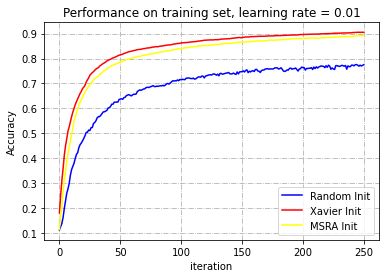

In [12]:
acc_init_plot(train_plot_data_random,train_plot_data_Xavier,train_plot_data_msra)

如上图所示，我们可以明显发现**Xavier初始化和Kaiming/MSRA初始化的表现要优于完全随机初始化**，仅训练两百轮即可达到90+的准确率，而且二者在收敛的过程中相对平缓，相对的，在完全随机初始化的情况下，同样的训练轮次只能达到75%的准确率，且不论在0.1和0.01的学习率情况下，都出现了明显的**震荡和波动**。

## 优化器方法

**接下来，我们尝试三种优化器方法**

### AdaGrad Optimizer

首先实现AdaGrad方法

它的算法流程如下：

grad_squared $=0$

While True:

$dx=$ compute_gradient $(x)$

$grad\_squared +=dx ** 2$

$x-= learning\_rate  * dx /  np.sqrt (grad\_squared)+\epsilon)$  ($\epsilon$防止除0)

AdaGrad通过累积过去的梯度调整学习率，缺点是在长时间的训练后容易导致每次更新的绝对值趋近于0

In [13]:
# 我们建立第四个神经网络，用于测试AdaGrad算法的性能

print('Network3:')
network3 = Two_Layers_Net(input_size=784, hidden_size=30, output_size=10, msra= False, Xavier = False)

batch_size = 128
learning_rate = 0.01
iteration = 250
epsilon = 1e-7

train_plot_data_adagrad = []

for Iter in range(iteration+1):
    batch_mask = np.random.choice(training_set_size, batch_size) # 随机选择
    x_batch = train_x[batch_mask]
    y_batch = train_y[batch_mask]
    # 使用误差反向传播法求梯度

    grad3 = network3.gradient(x_batch, y_batch)
    grad3_squared_W1 = grad3_squared_b1 = grad3_squared_W2 = grad3_squared_b2 = 0
    # 更新
    grad3_squared_W1 += grad3['W1']**2
    network3.params['W1'] -= learning_rate * grad3['W1']/np.sqrt((epsilon + grad3_squared_W1))
    grad3_squared_b1 += grad3['b1']**2
    network3.params['b1'] -= learning_rate * grad3['b1']/np.sqrt((epsilon + grad3_squared_b1))
    grad3_squared_W2 += grad3['W2']**2
    network3.params['W2'] -= learning_rate * grad3['W2']/np.sqrt((epsilon + grad3_squared_W2))
    grad3_squared_b2 += grad3['b2']**2
    network3.params['b2'] -= learning_rate * grad3['b2']/np.sqrt((epsilon + grad3_squared_b2))

    train_acc_adagrad = network3.accuracy(train_x,train_y)

    if Iter %25 ==0:
        print("AdaGrad(Radnom Init), iteration:",Iter,"train_accuracy: %.3f" % train_acc_adagrad)

    train_plot_data_adagrad.append(train_acc_adagrad)
    
    #AdaGrad

Network3:
Using Random Initialization
AdaGrad(Radnom Init), iteration: 0 train_accuracy: 0.104
AdaGrad(Radnom Init), iteration: 25 train_accuracy: 0.559
AdaGrad(Radnom Init), iteration: 50 train_accuracy: 0.707
AdaGrad(Radnom Init), iteration: 75 train_accuracy: 0.769
AdaGrad(Radnom Init), iteration: 100 train_accuracy: 0.804
AdaGrad(Radnom Init), iteration: 125 train_accuracy: 0.824
AdaGrad(Radnom Init), iteration: 150 train_accuracy: 0.834
AdaGrad(Radnom Init), iteration: 175 train_accuracy: 0.849
AdaGrad(Radnom Init), iteration: 200 train_accuracy: 0.857
AdaGrad(Radnom Init), iteration: 225 train_accuracy: 0.865
AdaGrad(Radnom Init), iteration: 250 train_accuracy: 0.872


In [14]:
def acc_optim_plot(data1,data2):
    line1, = plt.plot(data1,'blue',label = 'AdaGrad')
    line2, = plt.plot(data2,'red', label = 'Naive') # 记得加逗号，否则legend会找不到维度
    plt.title('Performance on training set, AdaGrad vs Naive')
    plt.legend(handles=[line1, line2], labels=['AdaGrad','Naive'], loc='best')
    plt.grid(linestyle='-.')
    plt.xlabel('iteration')
    plt.ylabel('Accuracy')
    plt.show()

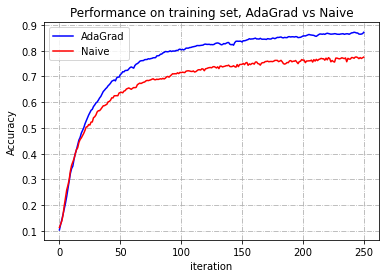

In [15]:
acc_optim_plot(train_plot_data_adagrad,train_plot_data_random)

可以看到，使用AdaGrad优化方法后，我们的网络在250轮次的训练后性能明显好于不使用优化器的原始网络。

### RMSProp Optimizer

RMSProp是一个与AdaGrad类似的算法，称之为“Leaky AdaGrad”，RMSProp算法不是像AdaGrad算法那样暴力直接的累加平方梯度，而是加了一个衰减系数（decay rate）来控制历史信息的获取多少。

主要的修改在累积梯度的计算上

$$ grad\_squared  = decay\_rate * grad\_squared + (1 - decay\_rate ) * dx ** 2 $$


In [16]:
# 我们建立第五个神经网络，用于测试RMSProp算法的性能
print('Network4:')
network4 = Two_Layers_Net(input_size=784, hidden_size=30, output_size=10, msra= False, Xavier = False)
decay_rate = 0.9
train_plot_data_rmsprop = []

print('RMSProp')
grad4_squared_W1 = grad4_squared_b1 = grad4_squared_W2 = grad4_squared_b2 = 0
for Iter in range(iteration+1):
    batch_mask = np.random.choice(training_set_size, batch_size) # 随机选择
    x_batch = train_x[batch_mask]
    y_batch = train_y[batch_mask]
    grad4 = network4.gradient(x_batch, y_batch)
    grad4_squared_W1 = (1 - decay_rate) * grad4['W1']**2 + decay_rate * grad4_squared_W1
    network4.params['W1'] -= learning_rate * grad4['W1']/np.sqrt((epsilon + grad4_squared_W1))
    grad4_squared_b1 = (1 - decay_rate) * grad4['b1']**2  + decay_rate * grad4_squared_b1
    network4.params['b1'] -= learning_rate * grad4['b1']/np.sqrt((epsilon + grad4_squared_b1))
    grad4_squared_W2 = (1 - decay_rate) * grad4['W2']**2 + decay_rate * grad4_squared_W2
    network4.params['W2'] -= learning_rate * grad4['W2']/np.sqrt((epsilon + grad4_squared_W2))
    grad4_squared_b2 = (1 - decay_rate) * grad4['b2']**2 + decay_rate * grad4_squared_b2
    network4.params['b2'] -= learning_rate * grad4['b2']/np.sqrt((epsilon + grad4_squared_b2))
    train_acc_rmsprop = network4.accuracy(train_x,train_y)
    if Iter %25 ==0:
        print("RMSPRop(Radnom Init), iteration:",Iter,"train_accuracy: %.3f" % train_acc_rmsprop)

    train_plot_data_rmsprop.append(train_acc_rmsprop)

Network4:
Using Random Initialization
RMSProp
RMSPRop(Radnom Init), iteration: 0 train_accuracy: 0.191
RMSPRop(Radnom Init), iteration: 25 train_accuracy: 0.627
RMSPRop(Radnom Init), iteration: 50 train_accuracy: 0.741
RMSPRop(Radnom Init), iteration: 75 train_accuracy: 0.796
RMSPRop(Radnom Init), iteration: 100 train_accuracy: 0.828
RMSPRop(Radnom Init), iteration: 125 train_accuracy: 0.842
RMSPRop(Radnom Init), iteration: 150 train_accuracy: 0.857
RMSPRop(Radnom Init), iteration: 175 train_accuracy: 0.861
RMSPRop(Radnom Init), iteration: 200 train_accuracy: 0.873
RMSPRop(Radnom Init), iteration: 225 train_accuracy: 0.884
RMSPRop(Radnom Init), iteration: 250 train_accuracy: 0.887


In [17]:
def acc_optim_plot3(data1,data2,data3):
    line1, = plt.plot(data1,'yellow',label = 'AdaGrad')
    line2, = plt.plot(data2,'green', label = 'RMSProp') # 记得加逗号，否则legend会找不到维度
    line3, = plt.plot(data3,'red', label = 'Naive') # 记得加逗号，否则legend会找不到维度
    plt.title('Performance: AdaGrad vs RMSProp vs Naive')
    plt.legend(handles=[line1, line2, line3], labels=['AdaGrad','RMSProp','Naive'], loc='best')
    plt.grid(linestyle='-.')
    plt.xlabel('iteration')
    plt.ylabel('Accuracy')
    plt.show()

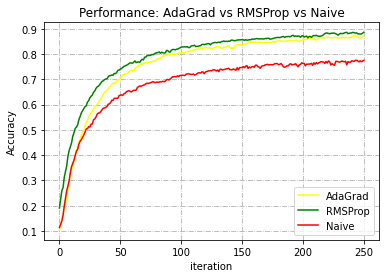

In [18]:
acc_optim_plot3(train_plot_data_adagrad,train_plot_data_rmsprop,train_plot_data_random)

RMSProp和AdaGrad在这个任务上的表现差不多（可能是因为数据集比较简单的缘故）

### Adam Optimizer

**接下来我们试一下Adam这个通用的优化器**

Adam综合了momentum和AdaGrad的思路，主要实现算法如下所示

While True:

$g_{t} \leftarrow \nabla_{\theta} f_{t}\left(\theta_{t-1}\right)$ (Get gradients w.r.t. stochastic objective at timestep $\left.t\right)$ 

$m_{t} \leftarrow \beta_{1} \cdot m_{t-1}+\left(1-\beta_{1}\right) \cdot g_{t}$ (Update biased first moment estimate)

$v_{t} \leftarrow \beta_{2} \cdot v_{t-1}+\left(1-\beta_{2}\right) \cdot g_{t}^{2}$ (Update biased second raw moment estimate) 

$\widehat{m}_{t} \leftarrow m_{t} /\left(1-\beta_{1}^{t}\right)$ (Compute bias-corrected first moment estimate)

$\widehat{v}_{t} \leftarrow v_{t} /\left(1-\beta_{2}^{t}\right)($ Compute bias-corrected second raw moment estimate $)$

$\theta_{t} \leftarrow \theta_{t-1}-\alpha \cdot \widehat{m}_{t} /\left(\sqrt{\widehat{v}_{t}}+\epsilon\right)($ Update parameters $)$

In [19]:
# 我们建立第六个神经网络，用于测试Adam算法的性能
print('Network5:')
network5 = Two_Layers_Net(input_size=784, hidden_size=30, output_size=10, msra= False, Xavier = False)
beta1 = 0.9
beta2 = 0.9
epsilon = 1e-7
train_plot_data_adam = []
learning_rate = 0.01
print('Adam Optimizer')

# 用一个列表，分别代表一节动量和二阶动量
Moment_W1 = [0,0]
Moment_W2 = [0,0]
Moment_b1 = [0,0]
Moment_b2 = [0,0]
 
# 这个地方Adam不使用无偏估计反而比无偏估计的表现要好...

for Iter in range(iteration+1):
    batch_mask = np.random.choice(training_set_size, batch_size) # 随机选择
    x_batch = train_x[batch_mask]
    y_batch = train_y[batch_mask]
    grad5 = network5.gradient(x_batch, y_batch)
    
    Moment_W1[0] = beta1 * Moment_W1[0] + (1-beta1) * grad5['W1'] 
    Moment_W1[1] = beta2 * Moment_W1[1] + (1-beta2) * grad5['W1']**2 
    W1_First_Moment_Unbias = Moment_W1[0]/((1-beta1**Iter)+epsilon)
    W1_Second_Moment_Unbias = Moment_W1[1]/((1-beta2**Iter)+epsilon)
    network5.params['W1'] -= learning_rate * Moment_W1[0]/(np.sqrt(Moment_W1[1])+epsilon)
    network5.params['W1'] -= learning_rate * grad5['W1']
    
    Moment_W2[0] = beta1 * Moment_W2[0] + (1-beta1) * grad5['W2'] 
    Moment_W2[1] = beta2 * Moment_W2[1] + (1-beta2) * grad5['W2']**2 
    W2_First_Moment_Unbias = Moment_W2[0]/((1-beta1**Iter)+epsilon)
    W2_Second_Moment_Unbias = Moment_W2[1]/((1-beta2**Iter)+epsilon)
    network5.params['W2'] -= learning_rate * Moment_W2[0]/(np.sqrt(Moment_W2[1])+epsilon)
    
    network5.params['b1'] -= learning_rate * grad5['b1']
    Moment_b1[0] = beta1 * Moment_b1[0] + (1-beta1) * grad5['b1'] 
    Moment_b1[1] = beta2 * Moment_b1[1] + (1-beta2) * grad5['b1']**2 
    b1_First_Moment_Unbias = Moment_b1[0]/((1-beta1**Iter)+epsilon)
    b1_Second_Moment_Unbias = Moment_b1[1]/((1-beta2**Iter)+epsilon)
    network5.params['b1'] -= learning_rate * Moment_b1[0]/(np.sqrt(Moment_b1[1])+epsilon)
    
    Moment_b2[0] = beta1 * Moment_b2[0] + (1-beta1) * grad5['b2'] 
    Moment_b2[1] = beta2 * Moment_b2[1] + (1-beta2) * grad5['b2']**2 
    b2_First_Moment_Unbias = Moment_b2[0]/((1-beta1**Iter)+epsilon)
    b2_Second_Moment_Unbias = Moment_b2[1]/((1-beta2**Iter)+epsilon)
    network5.params['b2'] -= learning_rate * Moment_b2[0]/(np.sqrt(Moment_b2[1])+epsilon)

    train_acc_adam = network5.accuracy(train_x,train_y)
    if Iter %25 ==0:
        print("Adam(Radnom Init), iteration:",Iter,"train_accuracy: %.3f" % train_acc_adam)

    train_plot_data_adam.append(train_acc_adam)

Network5:
Using Random Initialization
Adam Optimizer
Adam(Radnom Init), iteration: 0 train_accuracy: 0.096
Adam(Radnom Init), iteration: 25 train_accuracy: 0.680
Adam(Radnom Init), iteration: 50 train_accuracy: 0.794
Adam(Radnom Init), iteration: 75 train_accuracy: 0.824
Adam(Radnom Init), iteration: 100 train_accuracy: 0.842
Adam(Radnom Init), iteration: 125 train_accuracy: 0.852
Adam(Radnom Init), iteration: 150 train_accuracy: 0.870
Adam(Radnom Init), iteration: 175 train_accuracy: 0.874
Adam(Radnom Init), iteration: 200 train_accuracy: 0.877
Adam(Radnom Init), iteration: 225 train_accuracy: 0.888
Adam(Radnom Init), iteration: 250 train_accuracy: 0.891


In [20]:
def acc_optim_plot4(data1,data2,data3,data4):
    line1, = plt.plot(data1,'yellow',label = 'AdaGrad')
    line2, = plt.plot(data2,'green', label = 'RMSProp') # 记得加逗号，否则legend会找不到维度
    line3, = plt.plot(data3,'red', label = 'Naive') # 记得加逗号，否则legend会找不到维度
    line4, = plt.plot(data4,'blue', label = 'Adam') # 记得加逗号，否则legend会找不到维度
    plt.title('Performance: AdaGrad vs RMSProp vs Adam vs Naive')
    plt.legend(handles=[line1, line2, line3, line4], labels=['AdaGrad','RMSProp','Naive','Adam'], loc='best')
    plt.grid(linestyle='-.')
    plt.xlabel('iteration')
    plt.ylabel('Accuracy')
    plt.show()

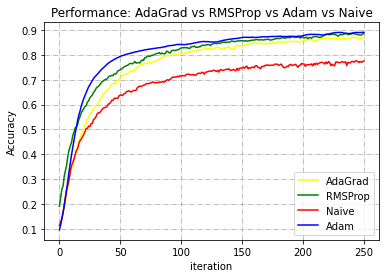

In [21]:
acc_optim_plot4(train_plot_data_adagrad,train_plot_data_rmsprop,train_plot_data_random,train_plot_data_adam)

我们发现，使用优化器方法的算法明显比Naive的梯度下降法好，而**Adam相比AdaGrad和RMSProp收敛的更加快一些**，最终都能在仅250轮训练的情况下获得90%的准确率，不过明显能感到Adam的计算更加费时间

最后，我们选择Kaiming初始化方法+RMSProp优化器训练这个模型，为了在尽可能小的训练轮次获得比较好的拟合情况，我们采用**学习率衰减**的方法来帮助收敛

最后再加入正则化项防止过拟合，其作用表现在反向传播的梯度之中，直接在反向传播的过程中实现


$$J(w, b)=\frac{1}{m} \sum_{i=1}^{m} L\left(\hat{y}^{(i)}, y^{(i)}\right)+\frac{\lambda}{2 m}\|w\|_{2}^{2}$$

不难发现，对后者求导后即直接基于权重参数和正则化强度进行更新

### 学习率衰减与正则化

我们建立最后一个个神经网络，用于最后的测试

In [22]:
print('The Last Network:')
network = Two_Layers_Net(input_size=784, hidden_size=30, output_size=10, msra= True, Xavier = False)
decay_rate = 0.97 # 学习率衰减
learning_rate = 0.1 # 学习率
epsilon = 1e-7 # 防止除0
batch_size = 256 # 批次大小
alpha = 0.08 # 正则化强度 
Iter_time = 5000 # 多训练几次让网络充分拟合
train_plot_data_rmsprop_kaiming = [] # 可以用来画图

Network:
Using MSRA/Kaiming Initialization


In [24]:
print('RMSProp + Adam')
grad_squared_W1 = grad_squared_b1 = grad_squared_W2 = grad_squared_b2 = 0
for Iter in range(Iter_time+1):
    batch_mask = np.random.choice(training_set_size, batch_size) # 随机选择
    x_batch = train_x[batch_mask]
    y_batch = train_y[batch_mask]
    grad = network.gradient(x_batch, y_batch)
    grad_squared_W1 = (1 - decay_rate) * grad['W1']**2 + decay_rate * grad_squared_W1
    network.params['W1'] -= learning_rate * grad['W1']/np.sqrt((epsilon + grad_squared_W1)) + alpha/batch_size*grad['W1']
    grad_squared_b1 = (1 - decay_rate) * grad['b1']**2  + decay_rate * grad_squared_b1
    network.params['b1'] -= learning_rate * grad['b1']/np.sqrt((epsilon + grad_squared_b1)) + alpha/batch_size*grad['b1']
    grad_squared_W2 = (1 - decay_rate) * grad['W2']**2 + decay_rate * grad_squared_W2
    network.params['W2'] -= learning_rate * grad['W2']/np.sqrt((epsilon + grad_squared_W2)) + alpha/batch_size*grad['W2']
    grad_squared_b2 = (1 - decay_rate) * grad['b2']**2 + decay_rate * grad_squared_b2
    network.params['b2'] -= learning_rate * grad['b2']/np.sqrt((epsilon + grad_squared_b2)) + alpha/batch_size*grad['b2']
    train_acc_rmsprop_kaiming = network.accuracy(train_x,train_y)
    if Iter % 500 == 0:
        learning_rate *= decay_rate
        print("RMSPRop(Kaiming Init), iteration:",Iter,"train_accuracy: %.4f" % train_acc_rmsprop_kaiming)

    train_plot_data_rmsprop_kaiming.append(train_acc_rmsprop_kaiming)

RMSProp + Adam
RMSPRop(Kaiming Init), iteration: 0 train_accuracy: 0.6477
RMSPRop(Kaiming Init), iteration: 500 train_accuracy: 0.9627
RMSPRop(Kaiming Init), iteration: 1000 train_accuracy: 0.9655
RMSPRop(Kaiming Init), iteration: 1500 train_accuracy: 0.9537
RMSPRop(Kaiming Init), iteration: 2000 train_accuracy: 0.9686
RMSPRop(Kaiming Init), iteration: 2500 train_accuracy: 0.9720
RMSPRop(Kaiming Init), iteration: 3000 train_accuracy: 0.9683
RMSPRop(Kaiming Init), iteration: 3500 train_accuracy: 0.9764
RMSPRop(Kaiming Init), iteration: 4000 train_accuracy: 0.9734
RMSPRop(Kaiming Init), iteration: 4500 train_accuracy: 0.9781
RMSPRop(Kaiming Init), iteration: 5000 train_accuracy: 0.9735


训练结束，如果不加入正则化项的话可以达到99%+（但是过拟合了就没用了），加入正则化项大约能收敛于正确率 97%-98%